In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


In [2]:
# Generate data paths with labels
data_dir = './data/Training'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_data = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
# Generate data paths with labels
data_dir = './data/Testing'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_data = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
df = pd.concat([train_data, test_data])

<Axes: xlabel='labels', ylabel='count'>

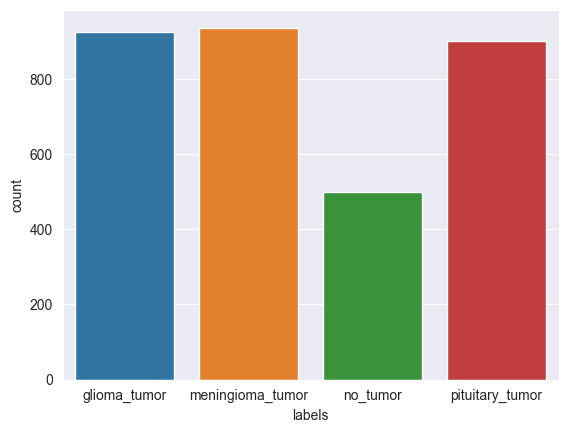

In [5]:
sns.countplot(data=df, x='labels')

In [6]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, random_state= 42,stratify=strat)

In [7]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2611 validated image filenames belonging to 4 classes.
Found 653 validated image filenames belonging to 4 classes.


In [11]:
classes = list(train_gen.class_indices.keys())
classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

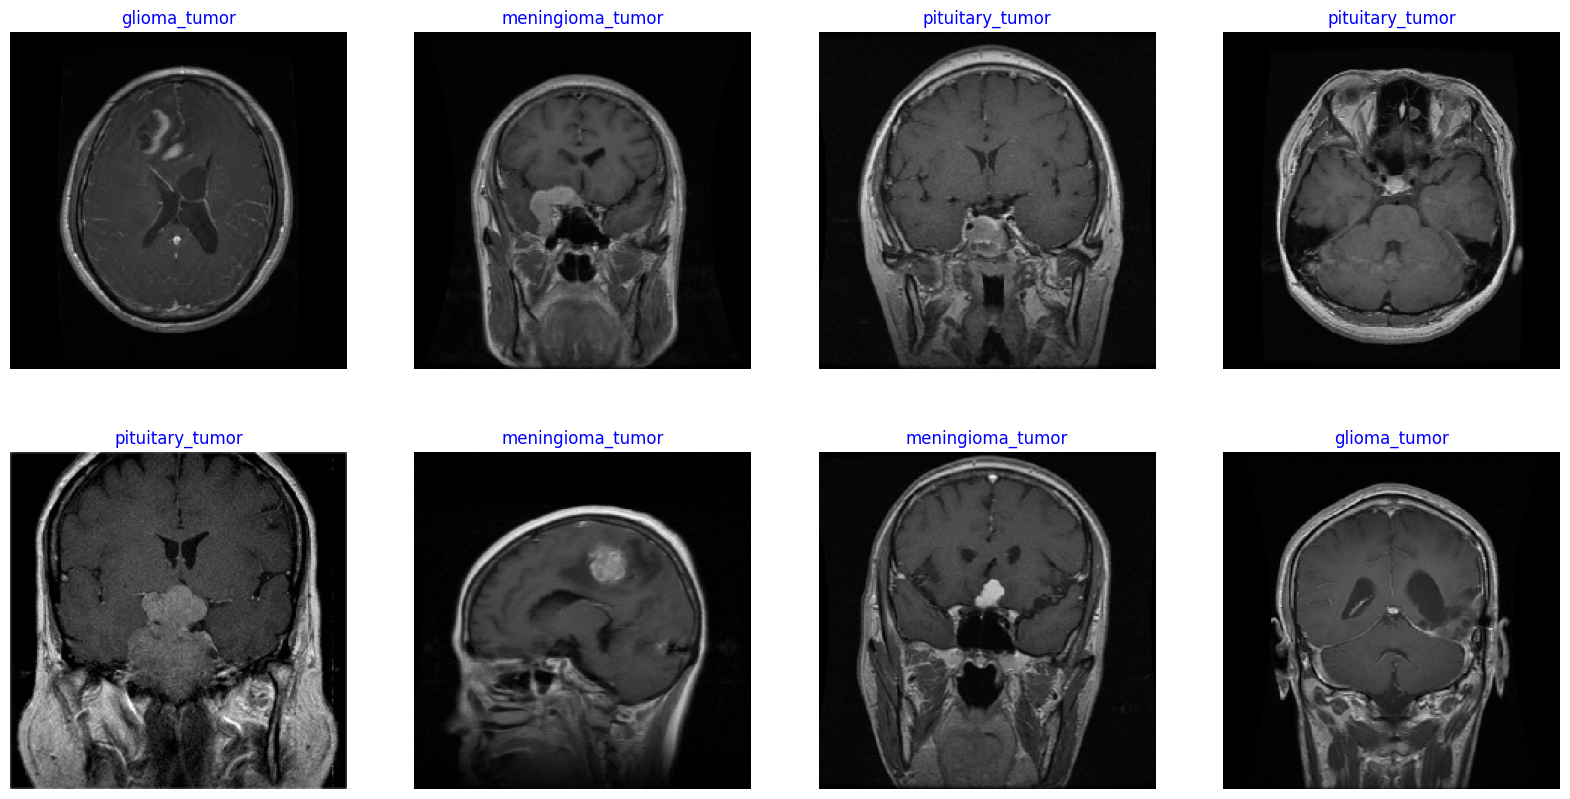

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 10))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [58]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

def make_model(learning_rate = 0.001 , size_inner=256, droprate=0.5):
    
    base_model = keras.applications.efficientnet_v2.EfficientNetV2B3(
        include_top= False,
        weights= "imagenet",
        input_shape= img_shape,
        pooling= 'max')
    
    base_model.trainable = False

    #########################################
    
    inputs = keras.Input(shape=img_shape)
    base = base_model(inputs, training=False)
    batch = keras.layers.BatchNormalization(axis= -1,
                                            momentum= 0.99,
                                            epsilon= 0.001)(base)
    inner = keras.layers.Dense(size_inner,
                               kernel_regularizer= regularizers.l2(l= 0.016),
                               activity_regularizer= regularizers.l1(0.006),
                               bias_regularizer= regularizers.l1(0.006),
                               activation='relu')(batch)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(class_count, activation= 'softmax')(drop)
    model = keras.Model(inputs, outputs)
    
     #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [59]:
model = make_model()
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 1536)              12930622  
 nal)                                                            
                                                                 
 batch_normalization_5 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_48 (Dense)            (None, 256)               393472    
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_49 (Dense)            (None, 4)                 102

In [61]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(x= train_gen, epochs=20, validation_data= test_gen)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/20
327/327 [==============================] - 27s 50ms/step - loss: 1.1578 - accuracy: 0.5733 - val_loss: 0.5010 - val_accuracy: 0.8315
Epoch 2/20
327/327 [==============================] - 11s 35ms/step - loss: 0.6607 - accuracy: 0.7434 - val_loss: 0.4069 - val_accuracy: 0.8606
Epoch 3/20
327/327 [==============================] - 11s 35ms/step - loss: 0.5279 - accuracy: 0.7993 - val_loss: 0.3613 - val_accuracy: 0.8698
Epoch 4/20
327/327 [==============================] - 12s 35ms/step - loss: 0.4458 - accuracy: 0.8338 - val_loss: 0.3388 - val_accuracy: 0.8698
Epoch 5/20
327/327 [==============================] - 11s 35ms/step - loss: 0.3757 - accuracy: 0.8533 - val_loss: 0.3005 - val_accuracy: 0.8821
Epoch 6/20
327/327 [==============================] - 12s 35ms/step - loss: 0.3133 - accuracy: 0.8778 - val_loss: 0.2915 - val_accuracy: 0.8836
Epoch 7/20
327/327 [==============================] - 11s 35ms/step - loss: 0.3084 - accuracy: 0.8786 - val_loss: 0.2689 - val_ac

In [63]:
del scores[0.1]
del scores[0.01]

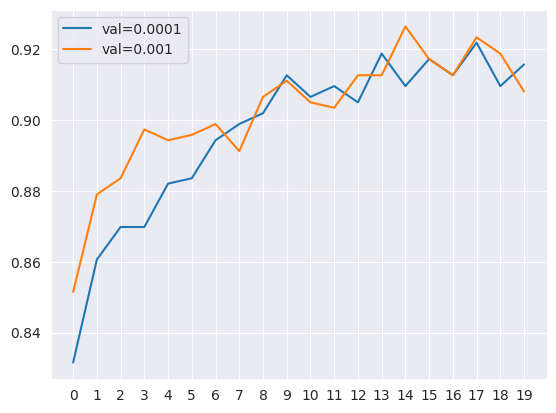

In [65]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(20))
plt.legend()

In [66]:
learning_rate = 0.001

scores = {}

for size in [32,128,256,512, 1024]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(x= train_gen, epochs=20, validation_data= test_gen)
    scores[size] = history.history

    print()
    print()

32
Epoch 1/20
327/327 [==============================] - 27s 51ms/step - loss: 1.0216 - accuracy: 0.6250 - val_loss: 0.4461 - val_accuracy: 0.8132
Epoch 2/20
327/327 [==============================] - 11s 35ms/step - loss: 0.6200 - accuracy: 0.7664 - val_loss: 0.3681 - val_accuracy: 0.8515
Epoch 3/20
327/327 [==============================] - 12s 36ms/step - loss: 0.5140 - accuracy: 0.8012 - val_loss: 0.3590 - val_accuracy: 0.8668
Epoch 4/20
327/327 [==============================] - 11s 35ms/step - loss: 0.4563 - accuracy: 0.8127 - val_loss: 0.3203 - val_accuracy: 0.8744
Epoch 5/20
327/327 [==============================] - 11s 34ms/step - loss: 0.4138 - accuracy: 0.8357 - val_loss: 0.3098 - val_accuracy: 0.8836
Epoch 6/20
327/327 [==============================] - 12s 35ms/step - loss: 0.3907 - accuracy: 0.8468 - val_loss: 0.2896 - val_accuracy: 0.8943
Epoch 7/20
327/327 [==============================] - 11s 35ms/step - loss: 0.3726 - accuracy: 0.8591 - val_loss: 0.3034 - val_accura

In [37]:
del scores[32]

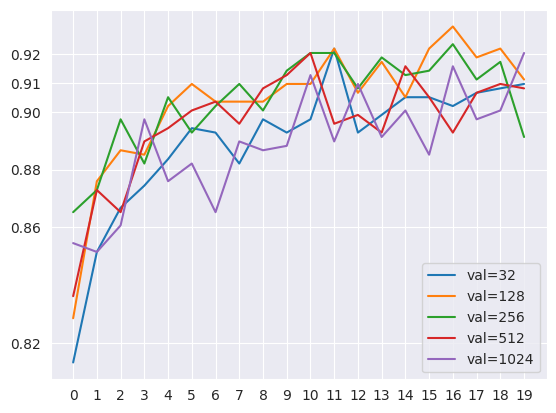

In [67]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(20))
plt.yticks([0.82, 0.86,0.88,0.90,0.91,0.92])
plt.legend()

In [68]:
learning_rate = 0.001
size = 128

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(x= train_gen, epochs=30, validation_data= test_gen)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/30
327/327 [==============================] - 25s 43ms/step - loss: 0.7306 - accuracy: 0.7602 - val_loss: 0.4260 - val_accuracy: 0.8438
Epoch 2/30
327/327 [==============================] - 12s 35ms/step - loss: 0.2752 - accuracy: 0.8985 - val_loss: 0.3603 - val_accuracy: 0.8897
Epoch 3/30
327/327 [==============================] - 12s 35ms/step - loss: 0.2059 - accuracy: 0.9223 - val_loss: 0.3706 - val_accuracy: 0.8821
Epoch 4/30
327/327 [==============================] - 12s 37ms/step - loss: 0.1268 - accuracy: 0.9552 - val_loss: 0.2990 - val_accuracy: 0.8928
Epoch 5/30
327/327 [==============================] - 12s 36ms/step - loss: 0.1358 - accuracy: 0.9521 - val_loss: 0.3116 - val_accuracy: 0.9005
Epoch 6/30
327/327 [==============================] - 12s 35ms/step - loss: 0.0920 - accuracy: 0.9621 - val_loss: 0.4066 - val_accuracy: 0.8867
Epoch 7/30
327/327 [==============================] - 11s 35ms/step - loss: 0.1137 - accuracy: 0.9590 - val_loss: 0.4756 - val_accur

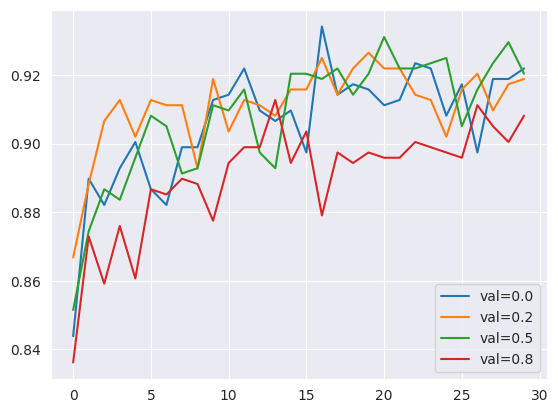

In [69]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

# plt.ylim(0.825, 0.95)
plt.legend()

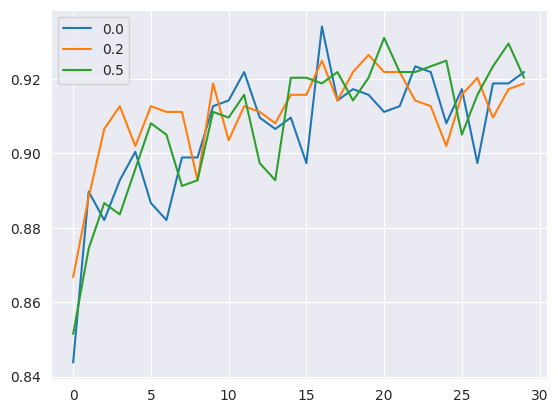

In [71]:
hist = scores[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

hist = scores[0.5]
plt.plot(hist['val_accuracy'], label=0.5)

plt.legend()
#plt.plot(hist['accuracy'], label=('val=%s' % droprate))

In [72]:
checkpoint = ModelCheckpoint(
    'EfficientNetV2B3_v2_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
    )

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [73]:
learning_rate = 0.001
size = 128
droprate = 0.5

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(x= train_gen,
                    epochs=30,
                    validation_data= test_gen,
                    callbacks=[checkpoint,early_stopping])

print()
print()

Epoch 1/30
327/327 [==============================] - 25s 45ms/step - loss: 1.0037 - accuracy: 0.6955 - val_loss: 0.5002 - val_accuracy: 0.8499
Epoch 2/30
327/327 [==============================] - 12s 36ms/step - loss: 0.5559 - accuracy: 0.8066 - val_loss: 0.3123 - val_accuracy: 0.8821
Epoch 3/30
327/327 [==============================] - 12s 36ms/step - loss: 0.4153 - accuracy: 0.8437 - val_loss: 0.2679 - val_accuracy: 0.8959
Epoch 4/30
327/327 [==============================] - 12s 36ms/step - loss: 0.3319 - accuracy: 0.8744 - val_loss: 0.2752 - val_accuracy: 0.8989
Epoch 5/30
327/327 [==============================] - 12s 37ms/step - loss: 0.2553 - accuracy: 0.9050 - val_loss: 0.2982 - val_accuracy: 0.9035
Epoch 6/30
327/327 [==============================] - 12s 37ms/step - loss: 0.2515 - accuracy: 0.9069 - val_loss: 0.2493 - val_accuracy: 0.9051
Epoch 7/30
327/327 [==============================] - 12s 36ms/step - loss: 0.2429 - accuracy: 0.9115 - val_loss: 0.2619 - val_accuracy:

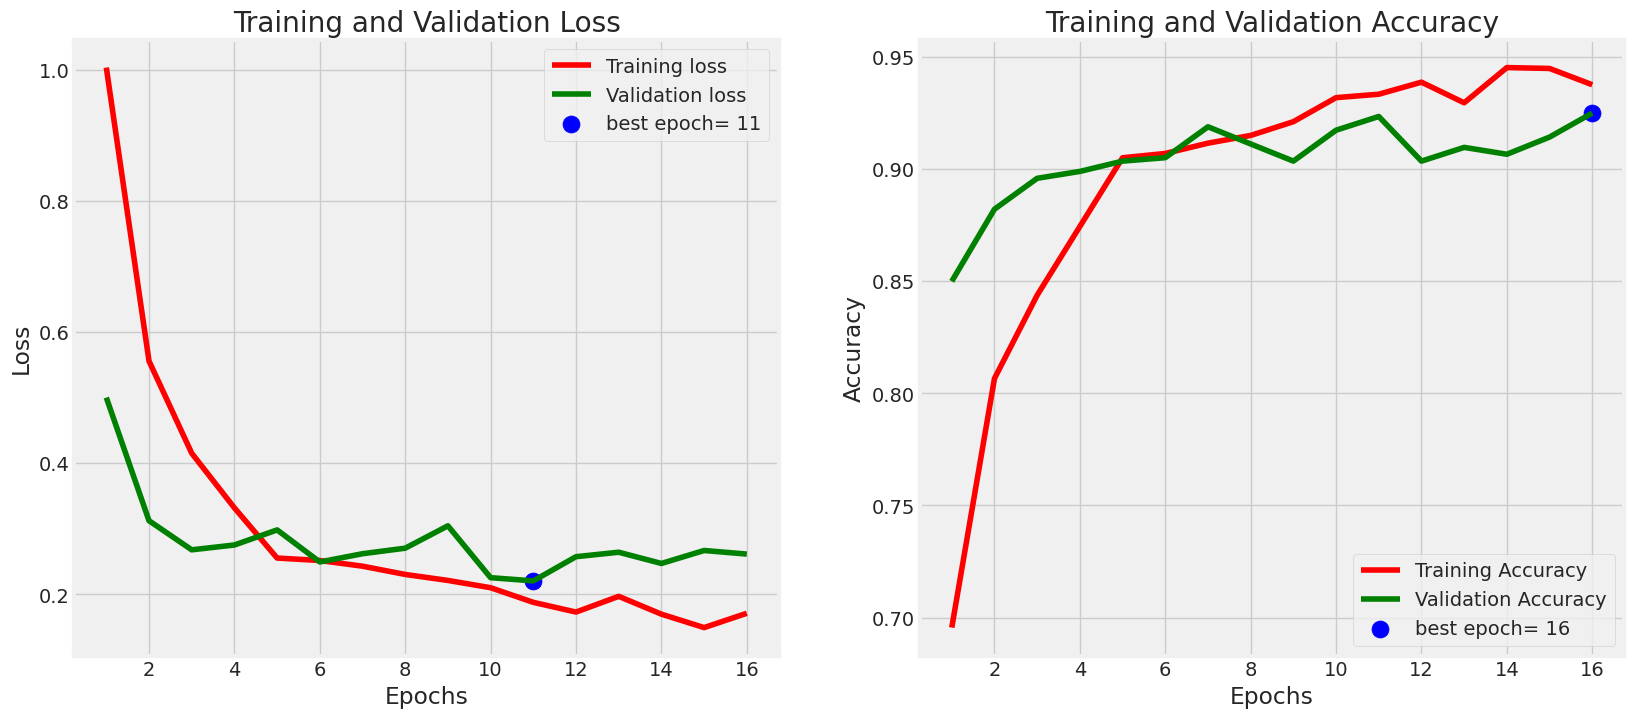

In [74]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [75]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

82/82 [==============================] - 2s 28ms/step - loss: 0.2204 - accuracy: 0.9234
Train Loss:  0.029210617765784264
Train Accuracy:  0.992340087890625
--------------------
Test Loss:  0.220436230301857
Test Accuracy:  0.923430323600769


In [76]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

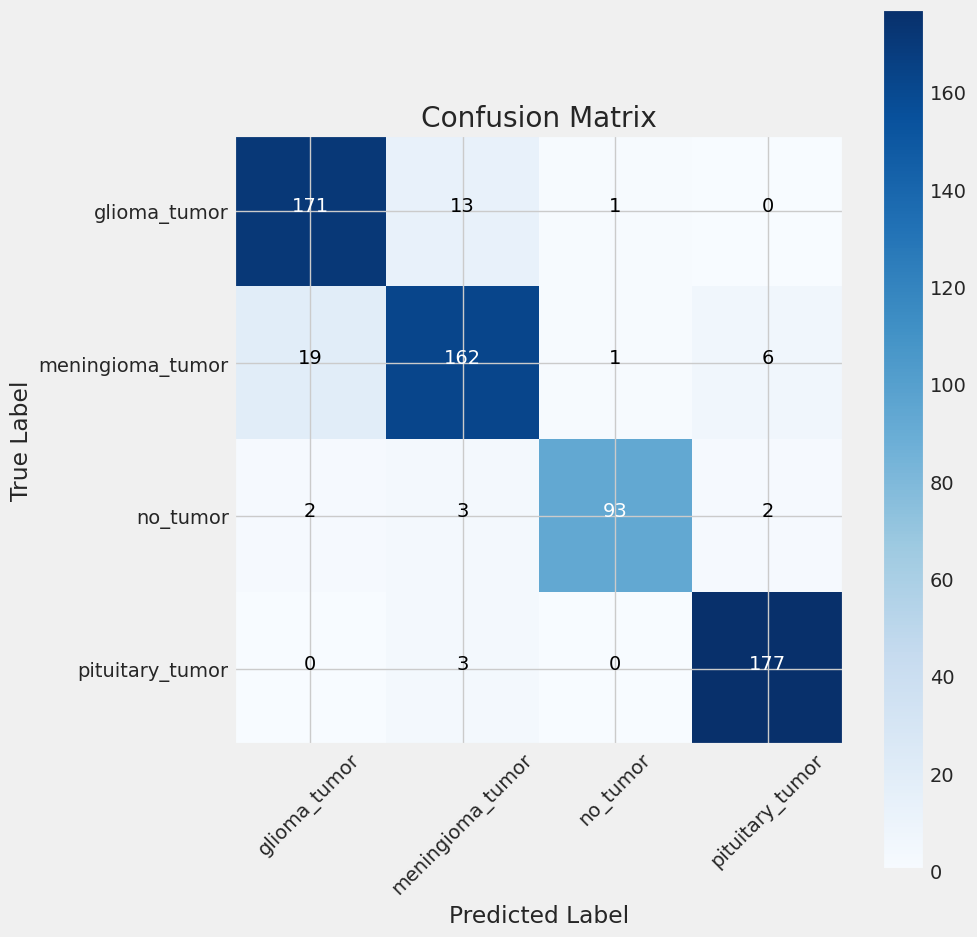

In [77]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [78]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.92      0.91       185
meningioma_tumor       0.90      0.86      0.88       188
        no_tumor       0.98      0.93      0.95       100
 pituitary_tumor       0.96      0.98      0.97       180

        accuracy                           0.92       653
       macro avg       0.93      0.92      0.93       653
    weighted avg       0.92      0.92      0.92       653

